In [258]:
import requests
import json

# To run this, create a credentials.py file containing your credentials
# CREDENTIALS = {'user':'???', 'password':'???'}

from credentials import CREDENTIALS

AUTH_URL = 'https://swift.oit.duke.edu/auth/v1.0/'

In [231]:
# The s=requests parameter is designed to default to using requests
# for requests.get, requests.post, etc.
# To use HTTP Persistent connections, pass a requests.Session() object  as s

def get_storage_url_and_token(s=requests):
    auth_headers = {'X-Auth-User': CREDENTIALS['user'], 'X-Auth-Key': CREDENTIALS['password']}
    response = s.get(AUTH_URL, headers=auth_headers)
    response.raise_for_status()
    auth_token = response.headers.get('X-Auth-Token')
    storage_url = response.headers.get('X-Storage-Url')
    return storage_url, auth_token

def headers(auth_token):
    return {'X-Auth-Token': auth_token}

def make_container(storage_url, auth_token, name, s=requests):
    dest_url =  '{}/{}'.format(storage_url, name)
    response = s.put(dest_url, headers=headers(auth_token))
    response.raise_for_status()

def upload_object(storage_url, auth_token, container, name, content, s=requests):
    dest_url = '{}/{}/{}'.format(storage_url, container, name)
    headers_dict = headers(auth_token)
    headers_dict['Content-Type'] = 'text/plain'
    response = s.put(dest_url, headers=headers_dict, data=content)
    response.raise_for_status()
    # Need to return etags and sizes
    return dict(etag=response.headers['Etag'], path='{}/{}'.format(container, name), size_bytes=len(content))

# Put a manifest
def make_slo(storage_url, auth_token, container, dest_name, manifest_entries, s=requests):
    dest_url = '{}/{}/{}'.format(storage_url, container, dest_name)
    response = s.put(dest_url, params={'multipart-manifest':'put'}, data=json.dumps(manifest_entries), headers=headers(auth_token))
    response.raise_for_status()

def get_object(storage_url, auth_token, container, name, s=requests):
    dest_url = '{}/{}/{}'.format(storage_url, container, name)
    response = s.get(dest_url, headers=headers(auth_token))
    return response.text


In [267]:
def make_containers(count, s=requests):
    for i in range(count):
        make_container(storage_url, token, 'container{}'.format(i), s)

def make_objects(container_i, count, size, s=requests):
    manifest_entries = []
    for i in range(count):
        file_name = 'file{}.txt'.format(i)
        contents = 'file{}'.format(i)
        manifest_entry = upload_object(storage_url, token, 'container{}'.format(container_i), file_name, 'x' * size, s)
        manifest_entries.append(manifest_entry)
    return manifest_entries

def make_slos(container_i, count, manifest_entries, s=requests):
    for i in range(count):
        make_slo(storage_url, token, 'container{}'.format(container_i), 'slo{}.txt'.format(i), manifest_entries, s)

## Configure requests

In [268]:
%time storage_url, token = get_storage_url_and_token()

CPU times: user 18.2 ms, sys: 2.36 ms, total: 20.5 ms
Wall time: 189 ms


## 10 Containers,  10 10k objects , 1 SLO
### With request.session()

In [269]:
s = requests.Session()

In [270]:
%time make_containers(10, s)

CPU times: user 168 ms, sys: 10.4 ms, total: 179 ms
Wall time: 1.66 s


In [281]:
%time manifest_entries = make_objects(0, 10, 10000, s)

CPU times: user 175 ms, sys: 9.85 ms, total: 185 ms
Wall time: 2.05 s


In [282]:
manifest_entries

[{'etag': 'b567fcb68d8555227123ab87e255872e',
  'path': 'container0/file0.txt',
  'size_bytes': 10000},
 {'etag': 'b567fcb68d8555227123ab87e255872e',
  'path': 'container0/file1.txt',
  'size_bytes': 10000},
 {'etag': 'b567fcb68d8555227123ab87e255872e',
  'path': 'container0/file2.txt',
  'size_bytes': 10000},
 {'etag': 'b567fcb68d8555227123ab87e255872e',
  'path': 'container0/file3.txt',
  'size_bytes': 10000},
 {'etag': 'b567fcb68d8555227123ab87e255872e',
  'path': 'container0/file4.txt',
  'size_bytes': 10000},
 {'etag': 'b567fcb68d8555227123ab87e255872e',
  'path': 'container0/file5.txt',
  'size_bytes': 10000},
 {'etag': 'b567fcb68d8555227123ab87e255872e',
  'path': 'container0/file6.txt',
  'size_bytes': 10000},
 {'etag': 'b567fcb68d8555227123ab87e255872e',
  'path': 'container0/file7.txt',
  'size_bytes': 10000},
 {'etag': 'b567fcb68d8555227123ab87e255872e',
  'path': 'container0/file8.txt',
  'size_bytes': 10000},
 {'etag': 'b567fcb68d8555227123ab87e255872e',
  'path': 'contain

In [283]:
%time make_slos(0, 1, manifest_entries, s)

CPU times: user 18.7 ms, sys: 2.44 ms, total: 21.1 ms
Wall time: 212 ms


- making a container takes 160ms
- making an object depends on the file size, but minimum 160ms. 205ms for a 10k file
- making a SLO depends on the number of objects and their size but takes a minimum 170ms

## 1 Container, 50 objects, 1 SLO

In [285]:
%time make_containers(1, s)
%time manifest_entries = make_objects(1, 50, 10000, s)
%time make_slos(1, 1, manifest_entries, s)

CPU times: user 17.9 ms, sys: 2.38 ms, total: 20.3 ms
Wall time: 170 ms
CPU times: user 858 ms, sys: 45.4 ms, total: 904 ms
Wall time: 10.3 s
CPU times: user 18.5 ms, sys: 1.1 ms, total: 19.6 ms
Wall time: 404 ms


- Creating a container took 169ms
- making 50 objects took 10.3s, so 206ms each
- making a SLO of 50 objects took 404ms

In [295]:
manifest_entries_10k = make_objects(2, 100, 10000, s)
sizes = []
for i in range(0,100,10):
    subset = manifest_entries[:i+10]
    sizes.append(len(subset))
    %time make_slos(3, 1, subset, s=requests)

CPU times: user 17.3 ms, sys: 845 µs, total: 18.1 ms
Wall time: 201 ms
CPU times: user 19 ms, sys: 1.06 ms, total: 20.1 ms
Wall time: 289 ms
CPU times: user 18.7 ms, sys: 1.23 ms, total: 20 ms
Wall time: 285 ms
CPU times: user 20.2 ms, sys: 1.17 ms, total: 21.4 ms
Wall time: 354 ms
CPU times: user 18.2 ms, sys: 1.07 ms, total: 19.2 ms
Wall time: 411 ms
CPU times: user 17.6 ms, sys: 1.05 ms, total: 18.6 ms
Wall time: 444 ms
CPU times: user 18.6 ms, sys: 1.11 ms, total: 19.7 ms
Wall time: 507 ms
CPU times: user 18.2 ms, sys: 1.05 ms, total: 19.2 ms
Wall time: 522 ms
CPU times: user 17.8 ms, sys: 1.14 ms, total: 19 ms
Wall time: 521 ms
CPU times: user 18.4 ms, sys: 1.13 ms, total: 19.6 ms
Wall time: 743 ms


In [296]:
times = [201,289,285,354,411,444,507,522,521,743]

In [297]:
import matplotlib

In [298]:
%matplotlib inline

In [299]:
from matplotlib.pyplot import plot

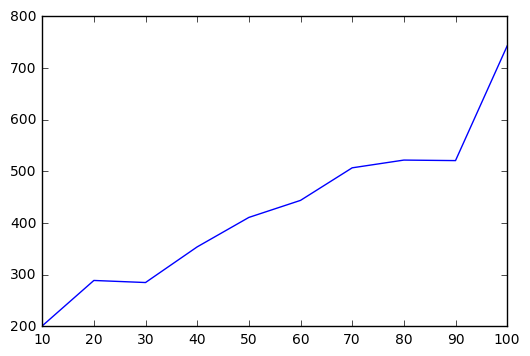

In [300]:
plot(sizes, times)

## Timing GET of 10 objects

In [301]:
%%time

for i in range(10):
    get_object(storage_url, token, 'container1','file{}.txt'.format(i), s)

CPU times: user 174 ms, sys: 9.88 ms, total: 184 ms
Wall time: 1.68 s


## Timing GET of /info

In [302]:
%%time
for i in range(10):
     s.get('https://swift.oit.duke.edu/info')

CPU times: user 176 ms, sys: 10.8 ms, total: 187 ms
Wall time: 1.48 s


## Confirming with bash

In [303]:
%%bash

time curl https://swift.oit.duke.edu/info 


{"formpost": {}, "slo": {"max_manifest_segments": 1000, "min_segment_size": 1, "max_manifest_size": 2097152}, "crossdomain": {}, "staticweb": {}, "tempurl": {"methods": ["GET", "HEAD", "PUT", "POST", "DELETE"]}, "swift": {"max_file_size": 5368709122, "account_listing_limit": 10000, "account_autocreate": true, "max_meta_count": 90, "max_meta_value_length": 256, "container_listing_limit": 10000, "max_meta_overall_size": 4096, "version": "2.3.0", "max_meta_name_length": 128, "max_header_size": 8192, "policies": [{"default": true, "name": "Policy-0"}], "max_object_name_length": 1024, "max_account_name_length": 256, "strict_cors_mode": true, "allow_account_management": true, "max_container_name_length": 256}}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   713  100   713    0     0   5000      0 --:--:-- --:--:-- --:--:--  5056

real	0m0.159s
user	0m0.015s
sys	0m0.005s


## Ping/latency info

In [304]:
%%bash

ping -c 10 swift.oit.duke.edu

PING swift-fitz.oit.duke.edu (152.3.72.68): 56 data bytes
64 bytes from 152.3.72.68: icmp_seq=0 ttl=247 time=0.906 ms
64 bytes from 152.3.72.68: icmp_seq=1 ttl=247 time=0.694 ms
64 bytes from 152.3.72.68: icmp_seq=2 ttl=247 time=0.839 ms
64 bytes from 152.3.72.68: icmp_seq=3 ttl=247 time=0.658 ms
64 bytes from 152.3.72.68: icmp_seq=4 ttl=247 time=0.680 ms
64 bytes from 152.3.72.68: icmp_seq=5 ttl=247 time=0.977 ms
64 bytes from 152.3.72.68: icmp_seq=6 ttl=247 time=0.797 ms
64 bytes from 152.3.72.68: icmp_seq=7 ttl=247 time=0.892 ms
64 bytes from 152.3.72.68: icmp_seq=8 ttl=247 time=0.747 ms
64 bytes from 152.3.72.68: icmp_seq=9 ttl=247 time=0.825 ms

--- swift-fitz.oit.duke.edu ping statistics ---
10 packets transmitted, 10 packets received, 0.0% packet loss
round-trip min/avg/max/stddev = 0.658/0.802/0.977/0.101 ms


On OIT desktop network, with sub 1ms ping to the host

## Another swift host

In [315]:
%%time
print "With requests.Session"
for i in range(10):
    response = s.get('https://swift.storm.gatech.edu/info')
    response.raise_for_status()
    

With requests.Session
CPU times: user 26.4 ms, sys: 3.9 ms, total: 30.3 ms
Wall time: 171 ms


In [316]:
%%time
print "Without requests.Session"
for i in range(10):
    response = requests.get('https://swift.storm.gatech.edu/info')
    response.raise_for_status()
    

Without requests.Session
CPU times: user 165 ms, sys: 10.9 ms, total: 176 ms
Wall time: 769 ms


- With persistent connections, swift.storm.gatech.edu returns /info  in an avg of 17ms
- without, the avg is 77ms
- I can't ping this host, but a nearby one varies from 10ms up to 600ms

In [325]:
%%bash
ping -c 10 new-pace-rtr.gatech.edu

PING new-pace-rtr.gatech.edu (143.215.254.202): 56 data bytes
64 bytes from 143.215.254.202: icmp_seq=0 ttl=244 time=10.635 ms
64 bytes from 143.215.254.202: icmp_seq=1 ttl=244 time=10.638 ms
64 bytes from 143.215.254.202: icmp_seq=2 ttl=244 time=11.787 ms
64 bytes from 143.215.254.202: icmp_seq=3 ttl=244 time=10.653 ms
64 bytes from 143.215.254.202: icmp_seq=4 ttl=244 time=11.109 ms
64 bytes from 143.215.254.202: icmp_seq=5 ttl=244 time=194.080 ms
64 bytes from 143.215.254.202: icmp_seq=6 ttl=244 time=91.998 ms
64 bytes from 143.215.254.202: icmp_seq=7 ttl=244 time=10.734 ms
64 bytes from 143.215.254.202: icmp_seq=8 ttl=244 time=31.437 ms
64 bytes from 143.215.254.202: icmp_seq=9 ttl=244 time=10.586 ms

--- new-pace-rtr.gatech.edu ping statistics ---
10 packets transmitted, 10 packets received, 0.0% packet loss
round-trip min/avg/max/stddev = 10.586/39.366/194.080/56.966 ms
